In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import collections
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tabulate import tabulate
from dateutil import parser
from collections import Counter
from itertools import chain

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zacha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zacha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
dirty_data = pd.read_csv('twcs.csv')
clean_data = dirty_data.copy()
sample_data = pd.read_excel('Sample Twitter Data.xlsx')

# What is Exploratory Data Analysis

Examining data in order to create an understanding of it

Doing exploratory data analysis helps to get an overview of the project and your goals before starting to code. 

Motives:
* Examine data distribution
* Handle missing values and duplicate data
* Handling outliers

Two main methods to accomplish this:
1. Graphical Analysis
	* Use of graphs to depict data
2. Non-graphical analysis
	* Use of words, code, and equations to depict data

A combination of both should be used.

This is based on the following: [Introduction to Exploratory Data Analysis](https://www.analyticsvidhya.com/blog/2021/02/introduction-to-exploratory-data-analysis-eda/)

# The meaning behind the data

This data looks at customer support interactions with customers. 

The columns are as follows:
* tweet_id 
    * Identifyer of the tweet
    * Data Type: Int
    * Cannot be blank
* author_id
    * Identifyer of the author
    * If it is support team it incorporates the team name while if it is a user it uses an id
    * Data Type: Object
    * Cannot be blank
* inbound
    * Boolean
    * True = directed at customer support
    * False = directed at a user
    * Data Type: Bool
    * Cannot be blank
* created_at
    * Date of creation
    * Data Type: Object
    * Cannot be blank
* text
    * Contents of the tweet
    * Data Type: Object
    * Cannot be blank
* response_tweet_id
    * Identifyer of the tweet that responeded to this one
    * Data Type: Float
    * Can be blank
* in_response_to_tweet_id
    * Identifyer of the tweet that this one is responding to
    * Data Type: Float
    * Can be blank

The following is an example of the relation between tweet_id, response_tweet_id, and in_response_to_tweet_id

Look at the following tweet we'll call Main Tweet: 

In [151]:
pd.option_context('display.max_colwidth', None)
example_tweet = sample_data[sample_data['tweet_id'] == 119241]
display(example_tweet)

tweet_id author_id  inbound                      created_at  \
4    119241    105836     True  Tue Oct 10 15:17:21 +0000 2017   

                                                                                                                              text  \
4  @VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k   

   response_tweet_id  in_response_to_tweet_id  
4           119243.0                 119240.0

Main Tweet has the id of 119241. It was responded to by a tweet with the id of 119243.

In [152]:
example_tweet_response = sample_data[sample_data['tweet_id'] == 119243]
display(example_tweet_response)

tweet_id     author_id  inbound                      created_at  \
5    119243  VirginTrains    False  Tue Oct 10 15:25:14 +0000 2017   

                                                     text  response_tweet_id  \
5  @105836 Have you tried from another device, Miriam ^MM           119244.0   

   in_response_to_tweet_id  
5                 119241.0

As you can see, the tweet_id of this tweet is the same as the response_tweet_id of Main Tweet.
The in_response_to_tweet_id of this tweet is the same as the tweet_id of Main Tweet.

In [153]:
example_tweet_in_response = sample_data[sample_data['tweet_id'] == 119240]
display(example_tweet_response)

tweet_id     author_id  inbound                      created_at  \
5    119243  VirginTrains    False  Tue Oct 10 15:25:14 +0000 2017   

                                                     text  response_tweet_id  \
5  @105836 Have you tried from another device, Miriam ^MM           119244.0   

   in_response_to_tweet_id  
5                 119241.0

Just as before, the in_response_to_tweet_id of this tweet is the same as the tweet_id of Main Tweet.

# Data Cleaning

* response_tweet_id and in_response_to_tweet_id should not have a decimal place when printed out
* Make sure tweet_id, author_id, inbound, created_at, and text are not blank
* Convert created_at to standerdized date that is easier to work with

## tweet_id

Tweet_ID must not be empty and there must be no duplicate values. We will check for that now

In [154]:
'''
Creates a DataFrame of all rows where 'tweeet_id' is empty:
1. Checks if the tweet_id has a value, True, or is NaN, False, and creates a Boolean Series
2. Creates a new DataFrame containing rows where 'tweet_id' is empty by boolean indexing
'''
tweet_id_empty = dirty_data[dirty_data['tweet_id'].isna()]

'''
Creates a DataFrame of all rows with duplicate 'tweet_id'
1. Checks if there are duplicates in 'tweet_id' and creates a Boolean Series of items with duplicates being True and without being False
2. Uses boolean indexing to create a DataFrame of all rows where 'tweet_id' has a duplicate
'''
tweet_id_duplicate = dirty_data[dirty_data.duplicated(subset=['tweet_id'],keep=False)]

print('There are no empty tweet ids' if tweet_id_empty.empty else tweet_id_empty)
print('There are no duplicate tweet ids' if tweet_id_duplicate.empty else tweet_id_duplicate)

There are no empty tweet ids
There are no duplicate tweet ids


Nothing further needs to be done as there are no empty tweet ids and no duplicate tweet ids

## author_id

We must check that there are no cells empty in 'author_id'

In [155]:
# Creates a DataFrame of all rows in dirty_data where 'author_id' is NaN
author_id_empty = dirty_data[dirty_data['author_id'].isna()]

print('There are no empty author ids' if author_id_empty.empty else author_id_empty)

There are no empty author ids


This means that no rows need to be removed as they have not author.

### Customer

#### Data Analysis

The total number of customers along with the top 20 customers will be displayed:

In [156]:
'''
Creates a DataFrame of all ids where the 'inbound' column is true
Creates boolean mask over 'inbound' column making it True where 'inbound' is True
Selects rows of the boolean mask that are true
Takes the 'author_id' column from the dirty_data DataFrame
Counts the occurrences of each unique 'author_id'
Changes the name of the columns to author_id and appearance_count
'''
customers = dirty_data[dirty_data['inbound'] == True]['author_id'].value_counts().reset_index()
customers.columns = ['author_id', 'appearance_count']

In [157]:
print(customers.head(20))

   author_id  appearance_count
0     115911              1286
1     120576              1010
2     115913               563
3     116230               454
4     169172               448
5     117627               406
6     115888               332
7     116136               295
8     116421               276
9     115722               252
10    115714               250
11    115850               243
12    115990               243
13    121239               210
14    203476               197
15    115725               194
16    115798               181
17    127296               176
18    170351               174
19    169916               172


It is apparent that their are outliers here and the data must be investigated further to check for discrepancies in the form of companies being identified as customers

#### Reviewing top customers

In [158]:
'''
The following function takes in an author_id
it displays all tweets made by that author in a tabular format
'''
def display_user_data(author_id):
    #makes sure all text is displayed and not cutoff
    pd.set_option('display.max_colwidth', None)
    
    # Creates a boolean mask that is True for rows where the 'author_id' column matches the provided author_id
    # Then applies the mask to the DataFrame and filters it to include only rows where the mask is True
    # Changes the column names to 'author_id' and 'text' 
    user_data = dirty_data[dirty_data['author_id'] == author_id][['author_id', 'text']]
    # Converts dataframe to list of lists
    data_list = user_data.values.tolist()
    headers = user_data.columns.tolist()
    
    # Prints it in an easy to read table
    print(tabulate(data_list, headers, tablefmt="grid"))

In [159]:
display_user_data('115911')

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                                |
+=============+=====================================================================================================================================================================================================================================================================================================+
|      115911 | @115910 No sir! You can still preorder at https://t.co

This the company Tmobile

In [160]:
display_user_data('120576')

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                        |
+=============+=============================================================================================================================================================================================================================================================================+
|      120576 | @VirginTrains @120720 Apologies Matt, the service is running 10 minutes late this morning due to a train fault. ^JC           

This is the company LNER

In [161]:
display_user_data('115913')

+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                                                 |
+=============+======================================================================================================================================================================================================================================================================================================================+
|      115913 | Wow

This is a Customer

In [162]:
display_user_data('116230')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                               |
+=============+====================================================================================================================================================================================================================================+
|      116230 | @116229 Gotcha. Have you shared your experience with us on the Feedback Hub? https://t.co/N8dIK5X2nH                                                                                                                               |
+-------------+-----

This is the company Microsoft

In [163]:
display_user_data('169172')

+-------------+---------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                  |
+=============+=======================================================================================================================================+
|      169172 | Hi @askvisa what is your policy/rules for merchants implementing minimum spend rule on visa card transactions in store? (Ireland)     |
+-------------+---------------------------------------------------------------------------------------------------------------------------------------+
|      169172 | @AmazonHelp @115830 Thanks, but it would be great to get a reply to my original tweet, at least the fake account replied. 8th day     |
+-------------+-------------------------------------------------------------------------

This is a Customer

In [164]:
display_user_data('117627')

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                                               |
+=============+====================================================================================================================================================================================================================================================================================================================+
|      117627 | @120454 @

This is the company GloWorld

In [165]:
display_user_data('115888')

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                          |
+=============+===============================================================================================================================================================================================+
|      115888 | Unli skips. Unli fun. 3 months of Premium for ₱9. https://t.co/Q2YbLhp7U6                                                                                                                     |
+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------

This is the company Spotify

In [166]:
display_user_data('116136')

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                            |
+=============+=================================================================================================================================================================================================================================================================================================+
|      116136 | We’re proud to announce that #InternetEssentials has connected 4 m

This is the company Comcast

In [167]:
display_user_data('116421')

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                            |
+=============+=================================================================================================================================================================================================================================================================================================+
|      116421 | @VirginTrains Night Joel                                          

This is a Customer

In [168]:
display_user_data('115722')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                           |
+=============+================================================================================================================================================================================================+
|      115722 | @115721 Hello Duke, Do you have a copy of your bill? What state are your services located in?                                                                                                  |
|             | ^NHP                                                                                                                                                

This is the company Verizon

In [169]:
display_user_data('115714')

+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                     |
+=============+==========================================================================================================================================================================================================+
|      115714 | Save big our best-selling phones, &amp; get FREE Upgrades to any phone after 12 consecutive on-time payments https://t.co/yvX1tLnLlZ                                                                     |
+-------------+-------------------------------------------------------------------------------------------------------------

This is the company Sprint

In [170]:
display_user_data('115850')

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                            |
+=============+=================================================================================================================================================================================================================================================================================================+
|      115850 | Hit ❤ or re-tweet to get notified when the OnePlus 5T sale begins,

This is the company amazonIN, the indian branch of amazon

In [171]:
display_user_data('115990')

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                             |
+=============+==================================================================================================================================================================================================================================================================================================+
|      115990 | @121795 We wish you felt differently. We appreciate having you 

This is the company Verizon

In [172]:
display_user_data('121239')

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                         |
+=============+==============================================================================================================================================================+
|      121239 | @AldiUK I think you may have to follow me so I cam DM you.                                                                                                   |
+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|      121239 | @AldiUK Aha... Just dropped you a DM...                                                                      

This is a Customer

In [173]:
display_user_data('203476')

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                                   |
+=============+========================================================================================================================================================================================================================================================================================================+
|      203476 | @SW_Help Well, which service will be a 450?  

This is a Customer

In [174]:
display_user_data('115725')

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                        |
+=============+=============================================================================================================================================================================+
|      115725 | @123436 Hello Julie, Our Financial Service Team can assist you with this @ 888 338-9333 after 8 am.                                                                         |
|             | ^NHP                                                                                                                                                                        |
+-------------+-----------------------------------

This is the company Verizon

In [175]:
display_user_data('115798')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                           |
+=============+================================================================================================================================================+
|      115798 | Lost your booking number? No worries, just drop me the passenger's name, flight details and email. I'll trace it and email u in no time :)     |
+-------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|      115798 | @124610 Hi Jeremy, the requests are still on process. You will be notified via email once refund request has been validated. Thanks -PR        |
+-------------+-------------------

This is the company AirAsia

In [176]:
display_user_data('127296')

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                            |
+=============+=================================================================================================================================================================================================================================================================================================+
|      127296 | @GWRHelp  https://t.co/bwSddQRBjZ                                 

This is a Customer

In [177]:
display_user_data('170351')

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                              |
+=============+===================================================================================================================================================================+
|      170351 | @AmericanAir @170350 It takes a long time to duct tape a plane together.                                                                                          |
+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|      170351 | @AmericanAir @170355 But #AAteam swears to my family we can't change flight because 

This is a Customer

In [178]:
display_user_data('169916')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

This is a Customer

In [179]:
display_user_data('117128')

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                 |
+=============+======================================================================================================================================================================================================================================================================================+
|      117128 | @120395 if any further assistance is needed. Thanks, Roslin                                        

This is a company Airtel

In [180]:
display_user_data('326613')

+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                     |
+=============+==========================================================================================================================================================+
|      326613 | @AmazonHelp Will someone from ur higher hierarchy call me. I have placed 145 orders on Amazon.in in last 12 months n u r hanging up on me!               |
+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|      326613 | @AmazonHelp It call center is absolutey pathetic! M told that the escalation heads email is __email__ is that so?                

This is a Customer

In [181]:
display_user_data('121428')

+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                         |
+=============+==============================================================================================================================================================================================================================================================================================+
|      121428 | @VirginTrains @121427 Sorry to hear it's cold on board Stacey, please speak

This is the company CrossCountryUK

In [182]:
display_user_data('118197')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                                                                                           |
+=============+================================================================================================================================================================================================================================================================================================+
|      118197 | @121720 Hi Mike,                                                     

This is the company Dell

In [183]:
display_user_data('134104')

+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                                                                         |
+=============+==============================================================================================================================================================================================================================+
|      134104 | @GWRHelp I was just wondering why it had to wait just after Worle                                                                                                                                                            |
+-------------+-----------------------------

This is a Customer

In [184]:
display_user_data('130560')

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   author_id | text                                                                                                                                                                        |
+=============+=============================================================================================================================================================================+
|      130560 | @VirginTrains Happy 5th birthday to my first 390 https://t.co/4lDcL6pWIB                                                                                                    |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|      130560 | @VirginTrains hay mm thanks to all

This is a Customer

#### Data Cleaning

The ids of companies identified as customers need to be replaced with their company name along with inbound being set to False and all occurances of the old ids in 'text' being updated to the new ids

The following are the old ids that need to be replaced along with the ids replacing them
| Old id | New id |
| --- | --- |   
| 120576 | LNER|
| 115911 | Tmobile|
| 116230 | Microsoft|
| 117627 | GloWorld|
| 115888 | Spotify|
| 116136 | Comcast|
| 115722 | Verizon|
| 115714 | Sprint|
| 115850 | amazonIN|
| 115990 | Verizon|
| 115725 | Verizon|
| 115798 | AirAsia|
| 121428 | CrossCountryUK|
| 118197 | Dell|
| 117128 | Airtel |

In [185]:
# Replaces all occurances of the old id with the new id and changes inbound to false
def replace_author_id(old_id, new_id):
    # Compares value of 'author_id' column to old_id and if they are equal set mask to True 
    mask = clean_data['author_id'] == old_id
    # Replaces every occurance of 'author_id' column to new_id where mask is True
    clean_data.loc[mask, 'author_id'] = new_id
    #Changes the value in the 'inbound' column to False where mask is True
    clean_data.loc[mask, 'inbound'] = False
    # Accesses 'text' column and replaces substring @old_id with @new_id 
    clean_data['text'] = clean_data['text'].str.replace(f"@{old_id}\\b", f"@{new_id}", regex=True)

In [186]:
# List of lists of all old ids next to their new ids
data = [
    ['115911', 'Tmobile'],
    ['120576', 'LNER'],
    ['116230', 'Microsoft'],
    ['117627', 'GloWorld'],
    ['115888', 'Spotify'],
    ['116136', 'Comcast'],
    ['115722', 'Verizon'],
    ['115714', 'Sprint'],
    ['115850', 'amazonIN'],
    ['115990', 'Verizon'],
    ['115725', 'Verizon'],
    ['115798', 'AirAsia'],
    ['121428', 'CrossCountryUK'],
    ['118197', 'Dell'],
    ['117128', 'Airtel']
]

In [187]:
# replaces all old_ids with their new_ids
for old_id, new_id in data:
    replace_author_id(old_id, new_id)

### Company

In [188]:
'''
Creates a DataFrame of all ids where the 'inbound' column is true
Creates boolean mask over 'inbound' column making it True where 'inbound' is False
Selects rows of the boolean mask that are true
Takes the 'author_id' column from the dirty_data DataFrame
Counts the occurrences of each unique 'author_id'
Changes the name of the columns to author_id and appearance_count
'''
companies = dirty_data[dirty_data['inbound'] == False]['author_id'].value_counts().reset_index()
companies.columns = ['author_id', 'appearance_count']

The following are the top 20 companies in terms of number of tweets

In [189]:
print(companies.head(20))

          author_id  appearance_count
0        AmazonHelp            169840
1      AppleSupport            106860
2      Uber_Support             56270
3      SpotifyCares             43265
4             Delta             42253
5             Tesco             38573
6       AmericanAir             36764
7       TMobileHelp             34317
8      comcastcares             33031
9   British_Airways             29361
10     SouthwestAir             28977
11     VirginTrains             27817
12     Ask_Spectrum             25860
13      XboxSupport             24557
14       sprintcare             22381
15     hulu_support             21872
16       sainsburys             19466
17          GWRHelp             19364
18   AskPlayStation             19098
19   ChipotleTweets             18749


### Everything

The following is the total number of unique authors:

In [190]:
'''
Creates a DataFrame of all ids 
Takes the 'author_id' column from the dirty_data DataFrame
Counts the occurrences of each unique 'author_id'
Changes the name of the columns to author_id and appearance_count
'''
total_author_ids = dirty_data['author_id'].value_counts().reset_index()
total_author_ids.columns = ['author_id', 'appearance_count']

In [191]:
print(total_author_ids.head(20))
print(f'\nTotal number of author ids: {len(total_author_ids)}')

          author_id  appearance_count
0        AmazonHelp            169840
1      AppleSupport            106860
2      Uber_Support             56270
3      SpotifyCares             43265
4             Delta             42253
5             Tesco             38573
6       AmericanAir             36764
7       TMobileHelp             34317
8      comcastcares             33031
9   British_Airways             29361
10     SouthwestAir             28977
11     VirginTrains             27817
12     Ask_Spectrum             25860
13      XboxSupport             24557
14       sprintcare             22381
15     hulu_support             21872
16       sainsburys             19466
17          GWRHelp             19364
18   AskPlayStation             19098
19   ChipotleTweets             18749

Total number of author ids: 702777


All top ids are those of companies 

## inbound

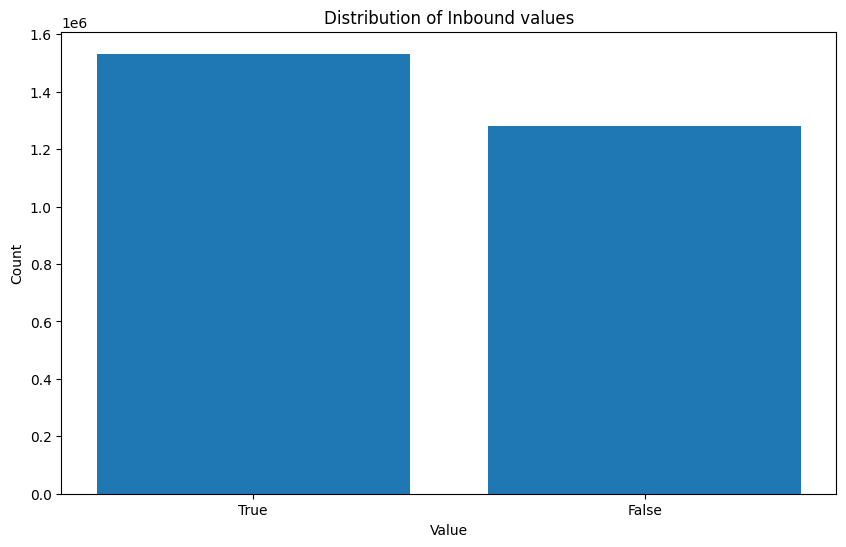


The difference between the two values is: 252660
The percentage difference between the first and second value is 19.75 %


In [192]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Inbound' is your column

# Count the number of True, False, and NaN values
counts = clean_data['inbound'].value_counts(dropna=False)

# Convert counts to DataFrame for better handling
counts_df = pd.DataFrame(counts).reset_index()

# Rename columns for better understanding
counts_df.columns = ['Value', 'Count']

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts_df['Value'].astype(str), counts_df['Count'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Distribution of Inbound values')
plt.show()

# Assuming 'counts_df' is your DataFrame and 'Count' is your column

value1 = counts_df.loc[0, 'Count']
value2 = counts_df.loc[1, 'Count']

diff = value1 - value2
percentage_diff = ((value1 - value2) / value2) * 100

print(f"\nThe difference between the two values is: {diff}")
print(f"The percentage difference between the first and second value is {percentage_diff:.2f} %")


## created_at

The current for mat of the date is: 
* day of week MMM DD HH:MM:SS time zone offset Year

A more ideal format is: 
* YYYY-MM-DD HH:MM:SS time zone offset

In [193]:
# Apply parsing to the 'created_at' column
clean_data['created_at'] = clean_data['created_at'].apply(lambda x: parser.parse(x))

In [194]:
# Get the count of the amount of null values
null_count = clean_data['created_at'].isnull().sum()
print(f"The following values did not convert correctly: {null_count}")

# Print the head of the DataFrame
print(tabulate(clean_data.head(1), headers='keys', tablefmt='psql'))

The following values did not convert correctly: 0
+----+------------+-------------+-----------+---------------------------+---------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------------+
|    |   tweet_id | author_id   | inbound   | created_at                | text                                                                                                                      |   response_tweet_id |   in_response_to_tweet_id |
|----+------------+-------------+-----------+---------------------------+---------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------------|
|  0 |          1 | sprintcare  | False     | 2017-10-31 22:10:47+00:00 | @115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist. |         

All created_at cells seem to have been converted to the proper format.

The following is a list of the dates with the most tweets

In [195]:
# Extract the date from datetime
clean_data['date'] = clean_data['created_at'].apply(lambda x: x.date())

# Count the occurrences of each date
date_counts = clean_data['date'].value_counts()

# Get the top 20 days with the most tweets
top_20_days = date_counts.head(20)
print(top_20_days)

date
2017-11-07    62793
2017-10-27    59136
2017-11-08    58169
2017-11-06    57981
2017-11-03    57233
2017-12-01    53857
2017-11-14    53731
2017-11-29    53610
2017-11-28    53538
2017-11-30    53476
2017-10-12    52499
2017-11-27    52467
2017-10-17    52116
2017-11-22    51980
2017-11-16    51807
2017-11-02    51642
2017-11-15    51347
2017-10-11    50921
2017-10-24    50797
2017-10-18    50598
Name: count, dtype: int64


## text

Before analysis of the text itself is done, there are certain elements that must be removed from the text. Emojis, punctuation, and @###### which are all examples of such items as they are irrelevant. 

In [196]:
# Function to remove emojis and emoticons
def remove_emojis_and_emoticons(data):
    # compiles pattern of different emojis in unicode
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"  # misc char
                           u"\U000024C2-\U0001F251"  # enclosed characters & more emojis
                           u"\U0001f926-\U0001f937"  # human emojis
                           u"\U00010000-\U0010ffff"  # Supplementary Multilingual Plane 
                           u"\u2640-\u2642"          # Female and male signs
                           u"\u2600-\u2B55"          # dingbats & weather symbols
                           u"\u200d"                 # zero width joiner
                           u"\u23cf"                 # eject button
                           u"\u23e9"                 # fast-forward button
                           u"\u231a"                 # clock emoji
                           u"\ufe0f"                 # variation selector
                           u"\u3030"                 # wavy dash
                           "]+", flags=re.UNICODE)
    # replace any occurance of the emoji pattern in data with an empty string
    data = emoji_pattern.sub(r'', data)

    # compile pattern of different emoticons
    emoticons_pattern = re.compile(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)')
    # replace any occurance of the emoticon pattern in data with an empty string
    data = emoticons_pattern.sub(r'', data)
    
    return data

# Function to remove @##### and punctuation
def clean_text(data):
    # replace all strings beginning with @ with an empty string
    data = re.sub('@[^\s]+','',data)
    
    # creates a string of all punctuation
    punctuation_extended = string.punctuation + '’' + '”'
    
    # creates translation table of punctuation to None and applies it
    data = data.translate(str.maketrans('', '', punctuation_extended))

    return data

# Apply cleaning functions to the data frame
clean_data['text'] = clean_data['text'].apply(remove_emojis_and_emoticons)
clean_data['text'] = clean_data['text'].apply(clean_text)

Stopwords are the most commonly used words in any language. All english stopwords must be removed.

In [197]:
# Get list of stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Set all text to lowercase
    tokenized_words = word_tokenize(text.lower())
    # creates a string of all words that are not stop words and joins them together
    filtered_text = (word for word in tokenized_words if word not in stop_words)
    return ' '.join(filtered_text)

# apply remove_stopwords function to dataframe
clean_data['text'] = clean_data['text'].map(remove_stopwords)

Now data analysis must be done to check the frequency of words and get rid of redundancies including very common and very uncommon words. 

In [198]:
# returns a list of words in a string
def tokenize_text(text):
    return word_tokenize(text)

# aapplies tokenize_text function to entire text column
word_tokens = clean_data['text'].map(tokenize_text)
# counts the frequency of words in token list
word_freq = Counter(chain.from_iterable(word_tokens))

In [199]:
# Getting most common and least common words
most_common_words = word_freq.most_common()[0:100]
least_common_words = word_freq.most_common()[:-101:-1] 

# Creating dataframes
most_common_df = pd.DataFrame(most_common_words, columns=["Word", "Frequency"])
least_common_df = pd.DataFrame(least_common_words, columns=["Word", "Frequency"])

# Displaying dataframes
print("Most common words:")
print(most_common_df.to_string(index=False))

print("\nLeast common words:")
print(least_common_df.to_string(index=False))

Most common words:
              Word  Frequency
                us     450044
            please     402696
                dm     334206
              help     265698
                hi     224655
            thanks     206712
               get     200445
             sorry     192547
                im     176519
              like     146332
              know     145205
              well     140857
              look     139253
              send     138952
           service     133848
            number     122980
           account     119870
             email     116599
             phone     113805
             thank     107853
              time     106608
             would     102157
               let     101420
              need     101401
             issue     100944
              dont      99339
              back      98929
              team      98535
           address      94559
             still      93442
               hey      91774
               see   

It appears that all words with over 15000 and less than 15 appearances are redundant and should be removed.

In [200]:
# filters words that appear more than 15 times and less than 15000 times
filtered_words = {word: freq for word, freq in word_freq.items() if 15 <= freq <= 15000}

# removes words that are not in filtered_words
def remove_words(text):
    return ' '.join(word for word in text.split() if word in filtered_words)

# applies the remove_words function to the enitre text column
clean_data['text'] = clean_data['text'].apply(remove_words)

## Response Combination

First, we will check to make sure that every tweet has a response and get a look at what the respoinse combination looks like

No Response: 0	Response Only: 794335	In Response Only: 1040629	Both Responses: 976810


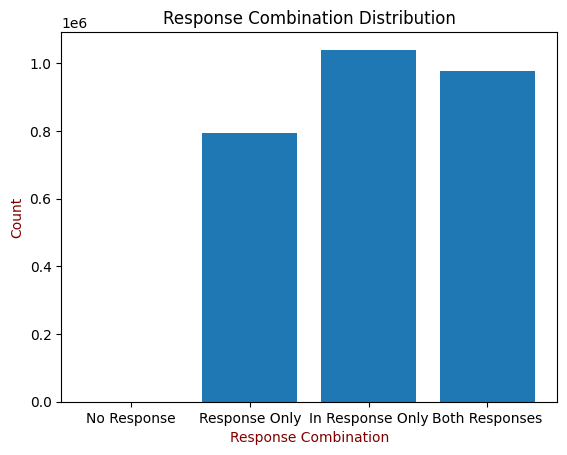

In [201]:
# Boolean mask for whether each type of response exists
response_exists = dirty_data['response_tweet_id'].notna()
in_response_exists = dirty_data['in_response_to_tweet_id'].notna()

# Count each type of combination
no_response = (~response_exists & ~in_response_exists).sum()
response_only = (response_exists & ~in_response_exists).sum()
in_response_only = (~response_exists & in_response_exists).sum()
both_responses = (response_exists & in_response_exists).sum()

# Relating labels to their values
labels = ['No Response', 'Response Only', 'In Response Only', 'Both Responses']
values = [no_response, response_only, in_response_only, both_responses]

print(f"No Response: {values[0]}\tResponse Only: {values[1]}\tIn Response Only: {values[2]}\tBoth Responses: {values[3]}")

# Create a bar chart
plt.bar(labels, values)
plt.xlabel('Response Combination').set_color('Maroon')
plt.ylabel('Count').set_color('Maroon')
plt.title('Response Combination Distribution')
plt.show()


There are no empty respones so that is not a problem and these categories seem to be good.

Here are the top authors based on number of tweets that are in response to another tweet:

In [202]:
# Get all rows where in_response_to_tweet_id is not None
response_tweets = clean_data[clean_data['in_response_to_tweet_id'].notna()]

# Count the occurrences of each 'author_id'
author_counts = response_tweets['author_id'].value_counts()

author_counts.head(20)

author_id
AmazonHelp         169287
AppleSupport       106719
Uber_Support        56261
SpotifyCares        43243
Delta               42197
Tesco               38501
AmericanAir         36598
TMobileHelp         34287
comcastcares        33007
British_Airways     29315
SouthwestAir        28889
VirginTrains        27522
Ask_Spectrum        25807
XboxSupport         24341
sprintcare          22335
hulu_support        21783
sainsburys          19417
GWRHelp             19294
AskPlayStation      18694
ChipotleTweets      18612
Name: count, dtype: int64

# Possible Applications

* Chatgpt could be used to analyize the tone of the response of the customer to see if they were satisfied or not 
* The amount of tweets between a customer support and a user could be looked at to see how long it took to solve the problem
* Chatgpt could be used to see what each inbound request is based on to get a general idea of the mind of the customer. Which category does the tweet fall under: product problem, disgrundtled with company, praise, etc.
* Date could be looked at to see the response time of support
* The contents of the tweet could be looked at to see who is using humans to respond and who is using pregenerated responses
* Chatgpt could be used to look at the content of the support team to verify how clear the response is and whether or not it has an approporiate tone